In [1]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

2023-06-03 16:06:59.007078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 16:07:00.195685: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-03 16:07:05.929611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-03 16:07:05.930003: W tensorflow/strea

tf.Tensor(-538.74255, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-03 16:07:12.493222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 16:07:12.493729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-03 16:07:12.500366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 16:07:12.513385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# <font color=maroon>Model Building (Baseline) - VGG
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model

In [4]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
pre_model.trainable = False

In [6]:
# build InceptionV3 model
model = Sequential(name='VGG_Baseline')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set)

Model: "VGG_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

2023-06-03 16:07:27.346411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-03 16:07:28.905477: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 16:07:28.906291: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 16:07:28.906437: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-03 16:07:28.907477: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-03 16:07:28.907610: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1563/1563 [==============================] - 88s 52ms/step - loss: 1.2359 - accuracy: 0.6785 - val_loss: 0.5494 - val_accuracy: 0.8357
Epoch 2/20
1563/1563 [==============================] - 78s 50ms/step - loss: 0.6719 - accuracy: 0.8037 - val_loss: 0.4920 - val_accuracy: 0.8584
Epoch 3/20
1563/1563 [==============================] - 78s 50ms/step - loss: 0.5754 - accuracy: 0.8343 - val_loss: 0.4901 - val_accuracy: 0.8636
Epoch 4/20
1563/1563 [==============================] - 77s 49ms/step - loss: 0.5252 - accuracy: 0.8538 - val_loss: 0.4685 - val_accuracy: 0.8596
Epoch 5/20
1563/1563 [==============================] - 77s 49ms/step - loss: 0.4714 - accuracy: 0.8689 - val_loss: 0.4613 - val_accuracy: 0.8756
Epoch 6/20
1563/1563 [==============================] - 78s 50ms/step - loss: 0.4544 - accuracy: 0.8780 - val_loss: 0.4705 - val_accuracy: 0.8746
Epoch 7/20
1563/1563 [==============================] - 77s 49ms/step - loss: 0.4278 - accuracy: 0.8877 - val_loss: 0.5508 - val_accura

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 13s 40ms/step - loss: 0.6927 - accuracy: 0.8736
Test loss:  0.6926953196525574
Test accuracy: 0.8736000061035156


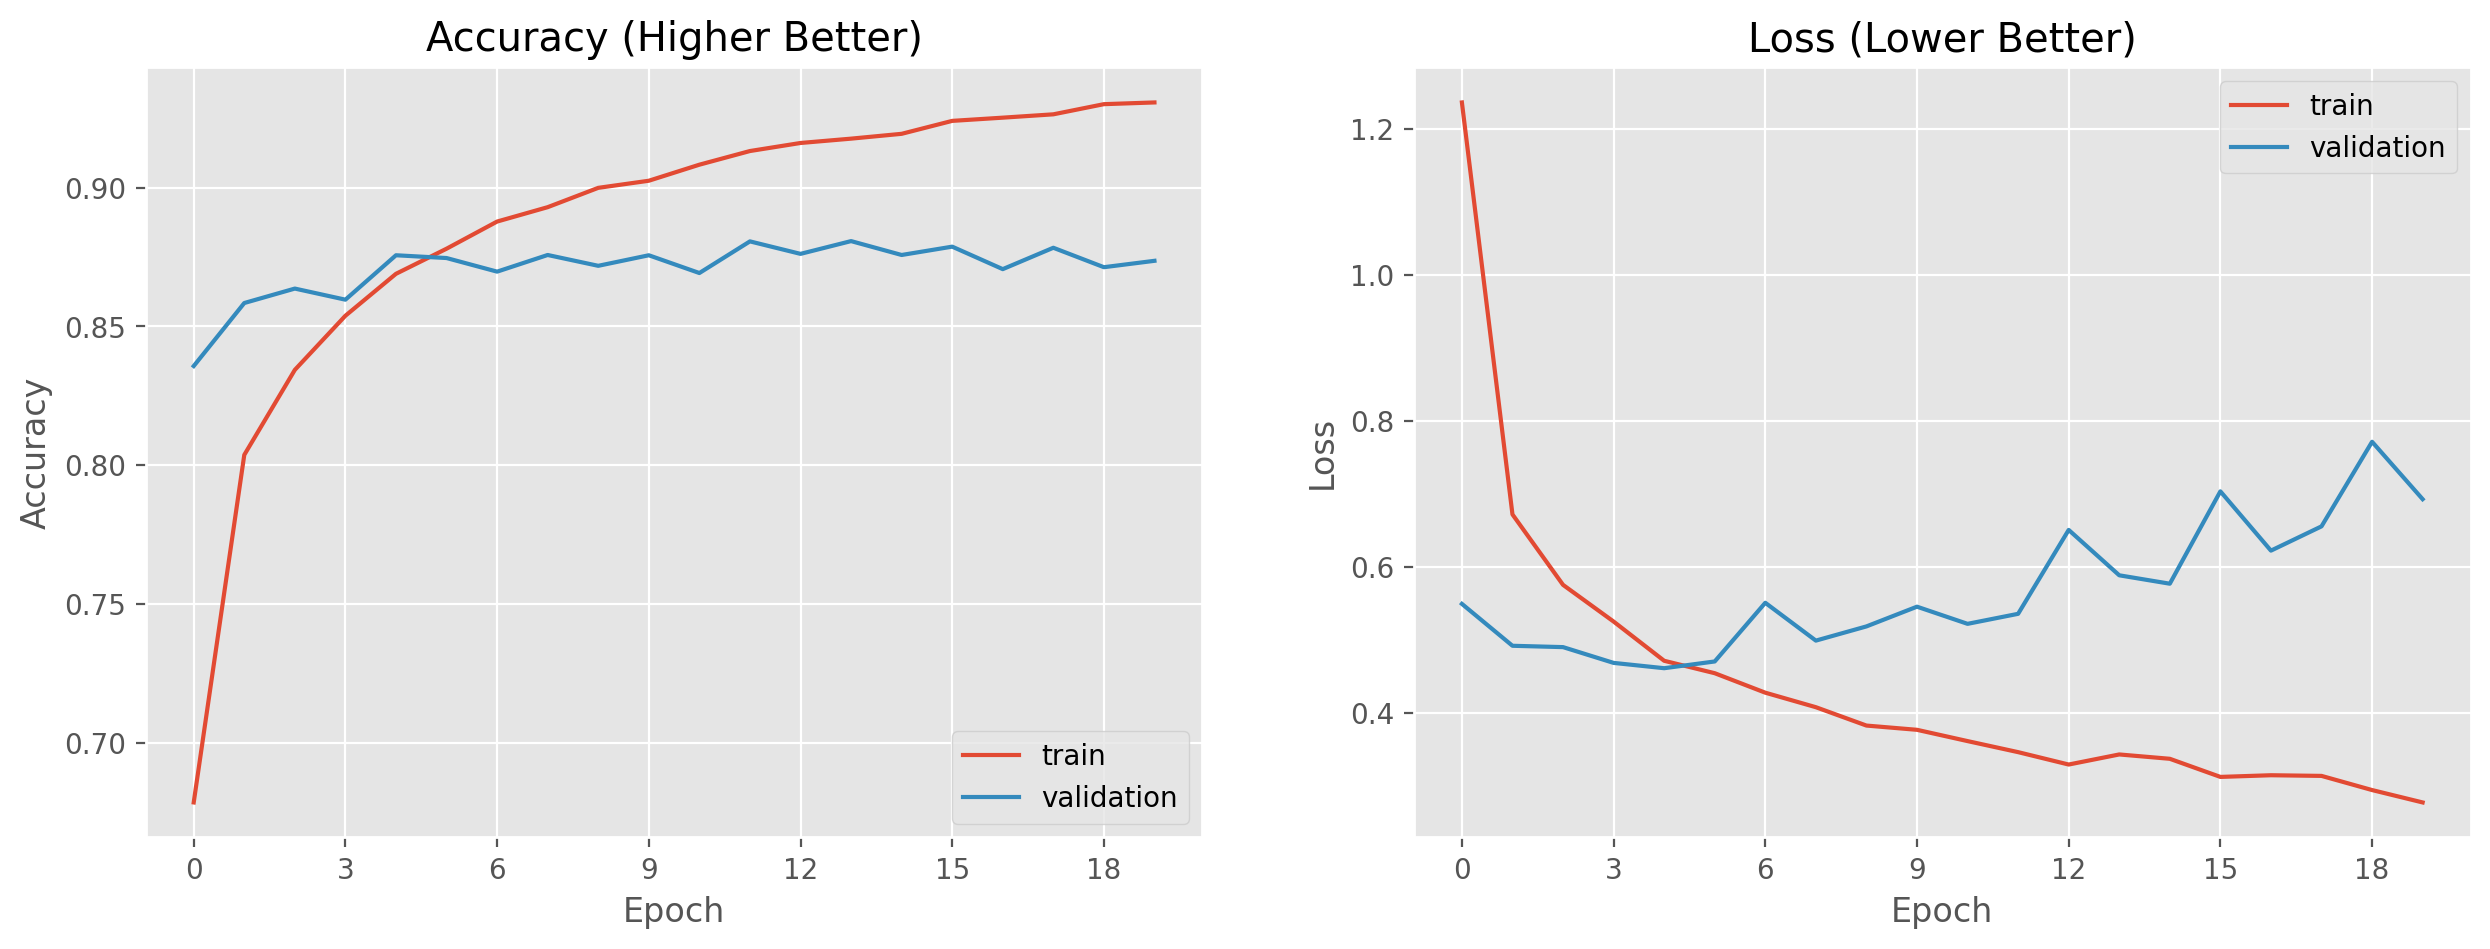

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 11s 35ms/step
[3 8 1 ... 5 1 7]


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [11]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


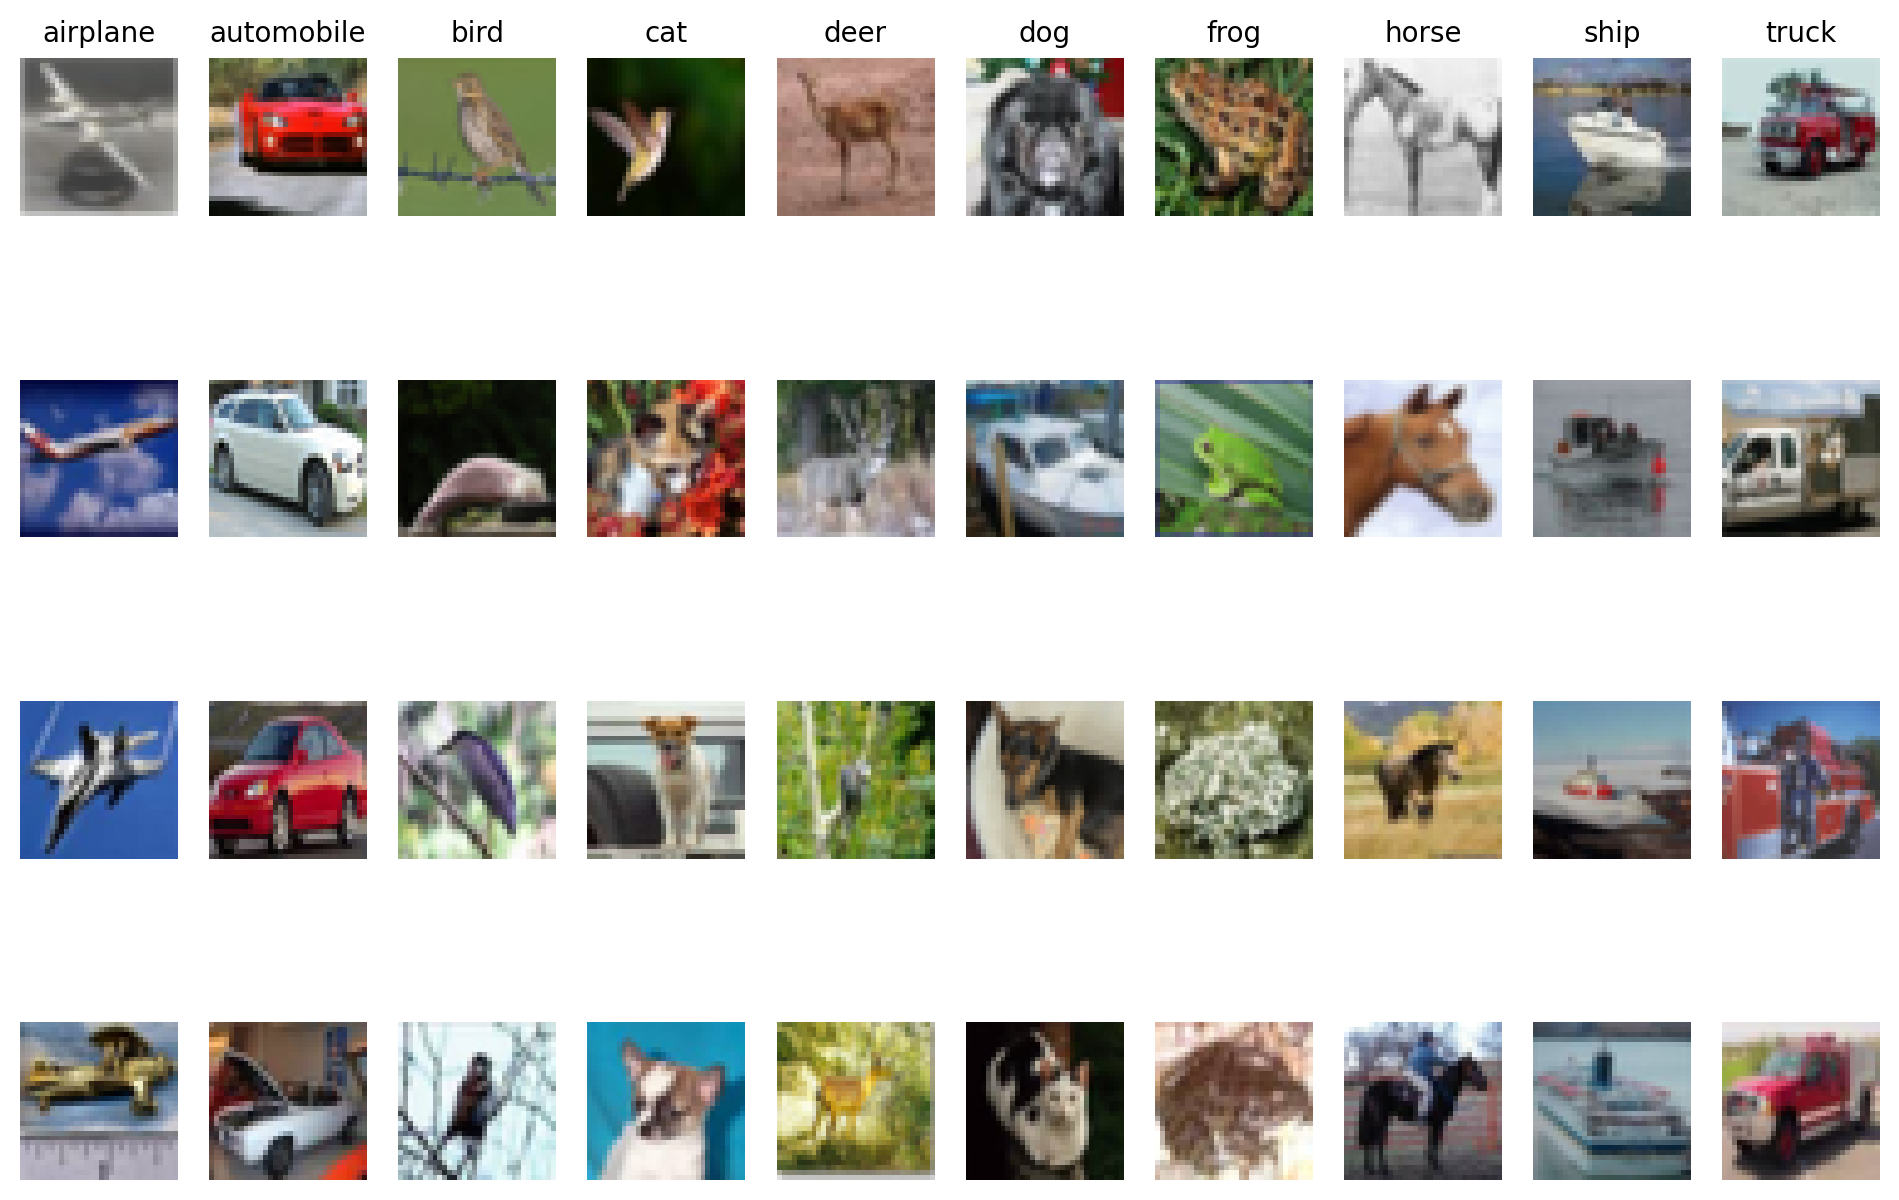

In [13]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=maroon>Testing categorising on a single model

### Imports

In [14]:
import requests
from PIL import Image
from io import BytesIO

In [15]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [16]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [17]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [18]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 1s 667ms/step


In [19]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [20]:
predicted_label = class_labels[predicted_class_index[0]]

In [21]:
print(predicted_label)


dog


### <font color=maroon>Visualising confusion matrix

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [23]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [24]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.8736


In [25]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.886666780027738
Recall: 0.8736
F1 Score: 0.8764183409379277


### Creating confusion matrix

In [26]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

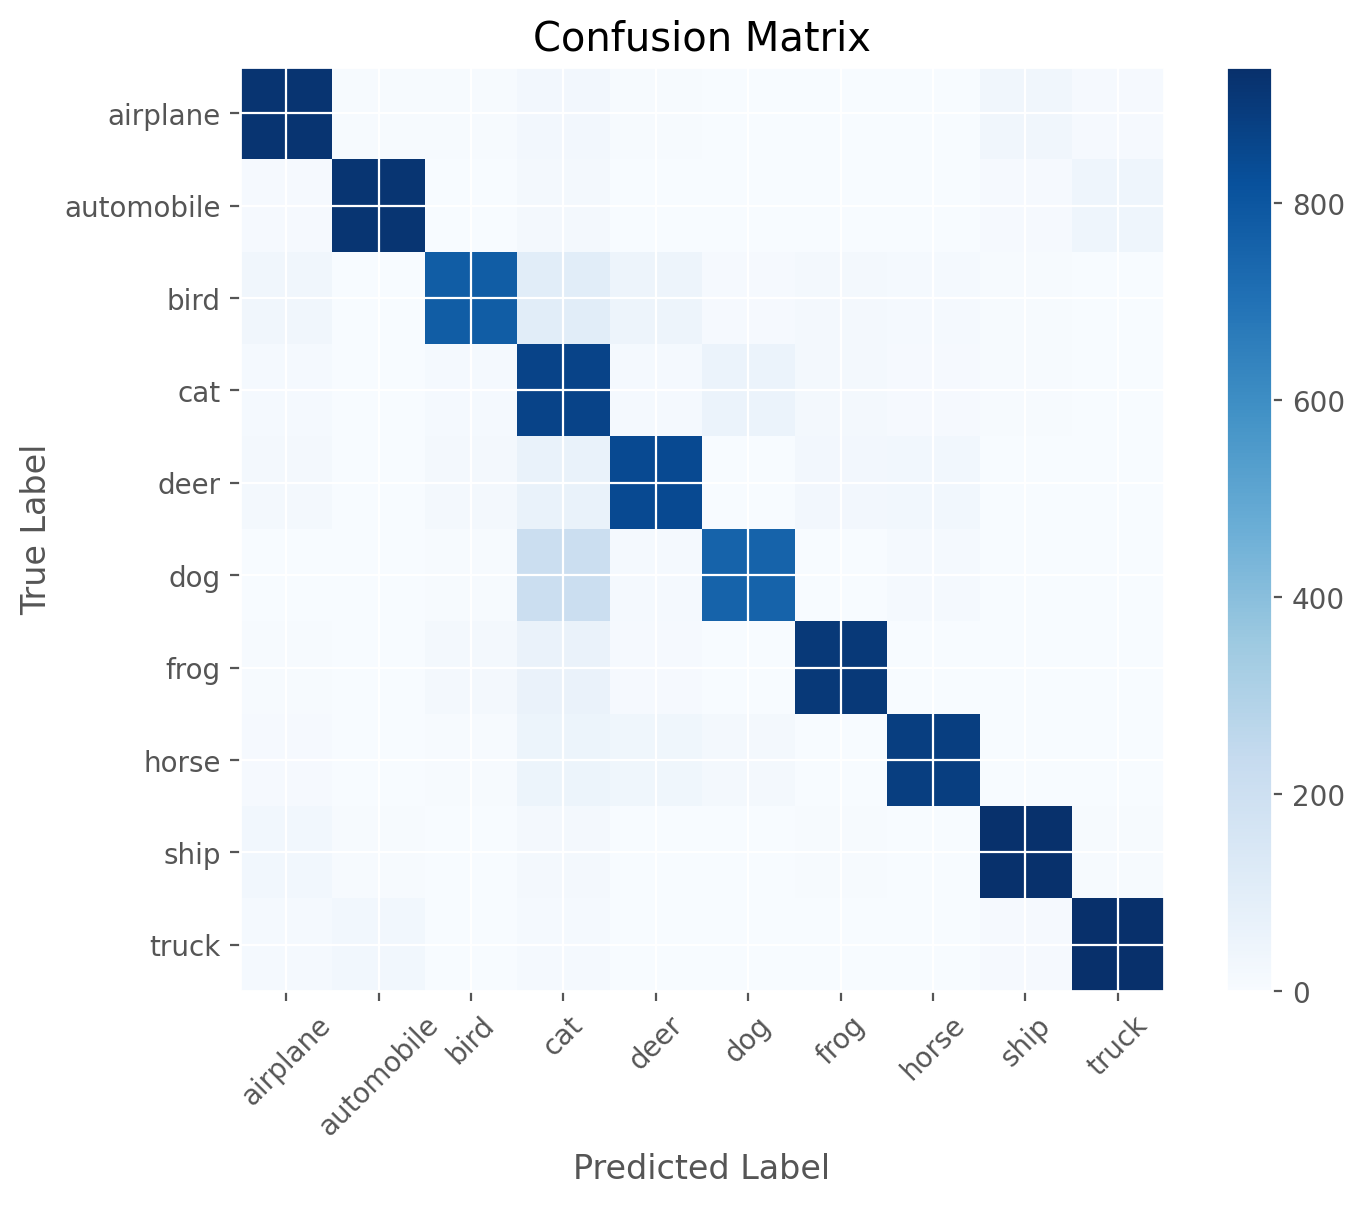

In [27]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [28]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.87      0.92      0.90      1000
  automobile       0.96      0.92      0.94      1000
        bird       0.92      0.77      0.84      1000
         cat       0.61      0.87      0.72      1000
        deer       0.87      0.84      0.86      1000
         dog       0.90      0.75      0.82      1000
        frog       0.92      0.90      0.91      1000
       horse       0.93      0.89      0.91      1000
        ship       0.94      0.93      0.93      1000
       truck       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.88     10000
weighted avg       0.89      0.87      0.88     10000



# <font color=maroon>Model Building (Tuned 1) - VGGT
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler

In [4]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [6]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_first1')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
  return 0.001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_first1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)          

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 20s 64ms/step - loss: 0.3914 - accuracy: 0.9153
Test loss:  0.39144572615623474
Test accuracy: 0.9153000116348267


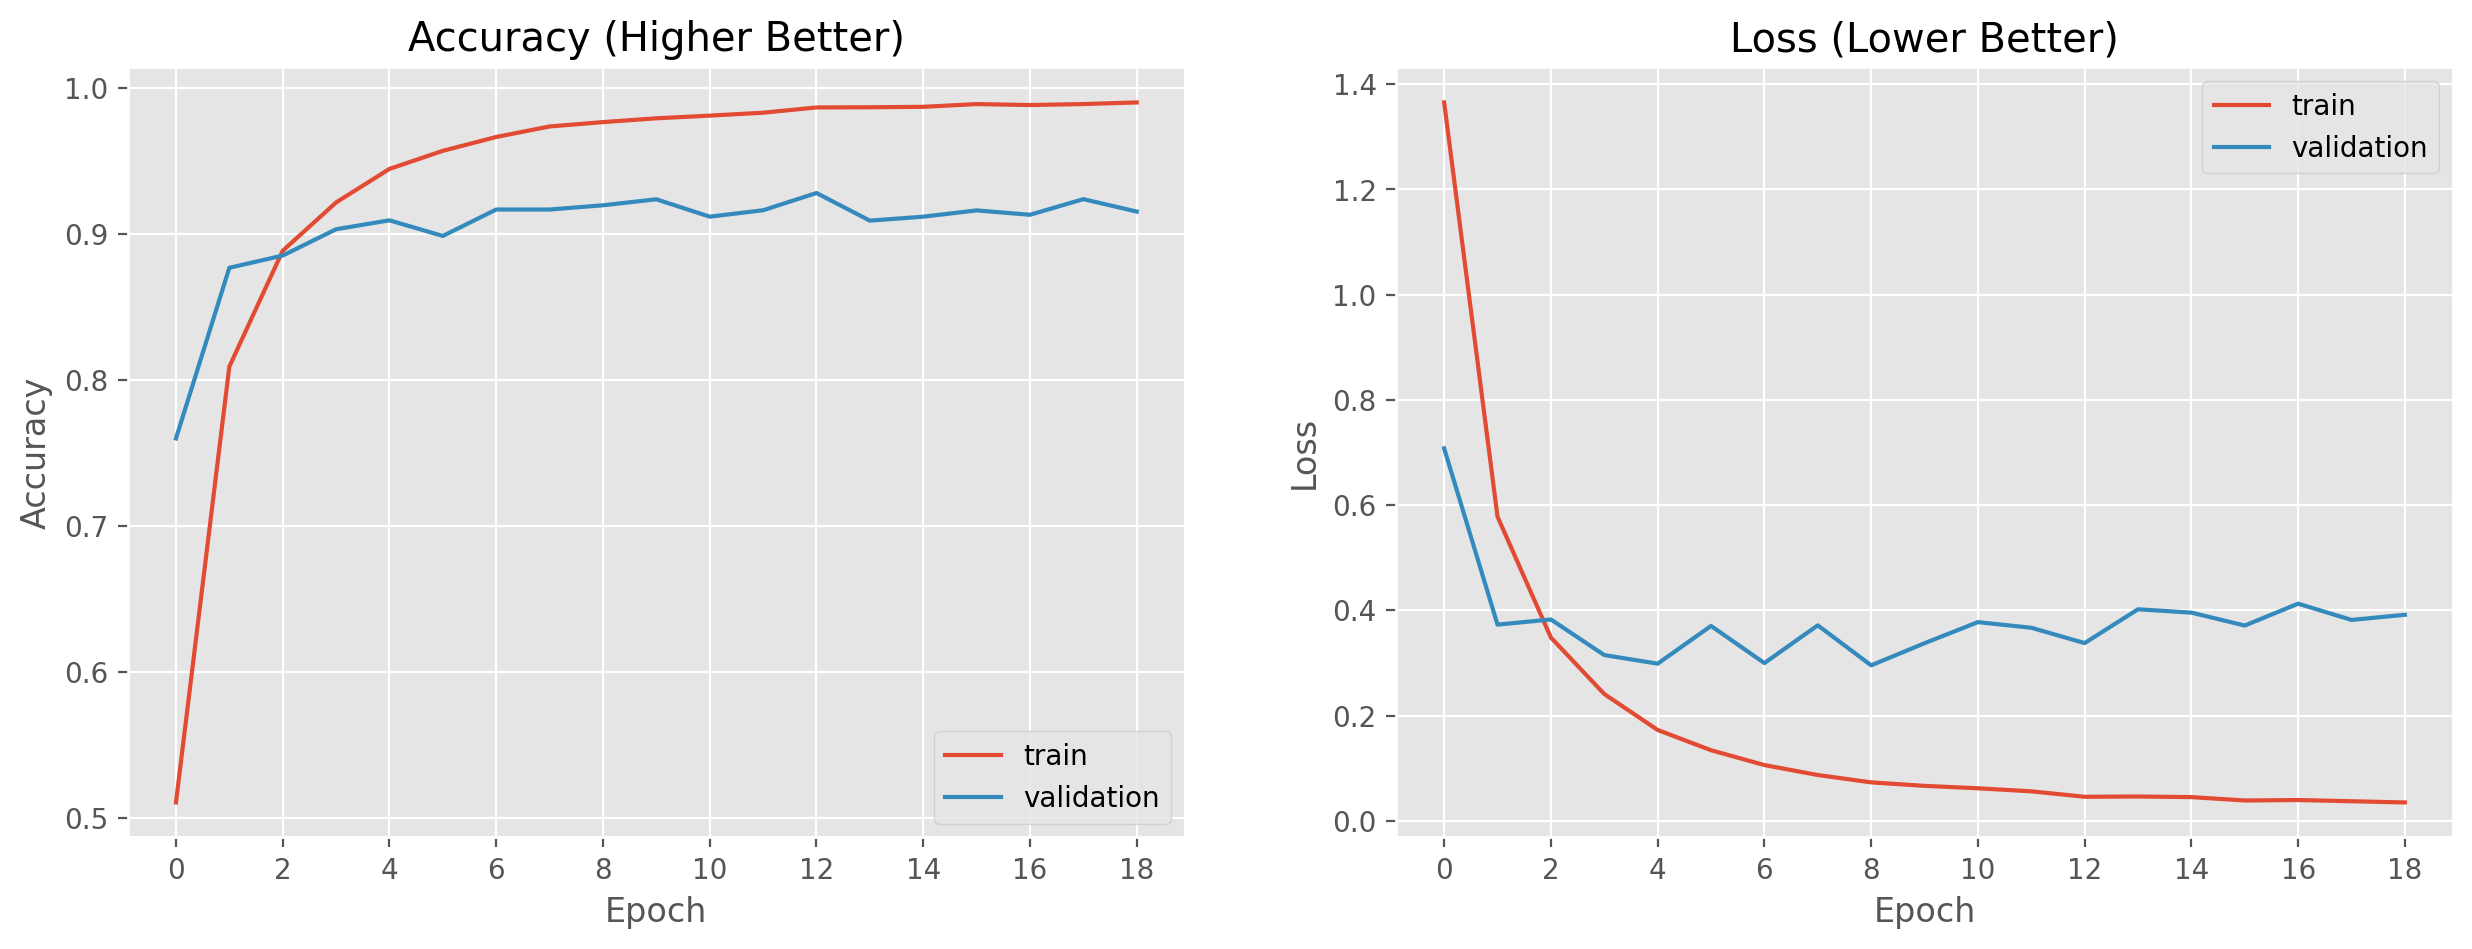

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 18s 58ms/step
[3 8 8 ... 5 1 7]


In [19]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [20]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [21]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_31/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


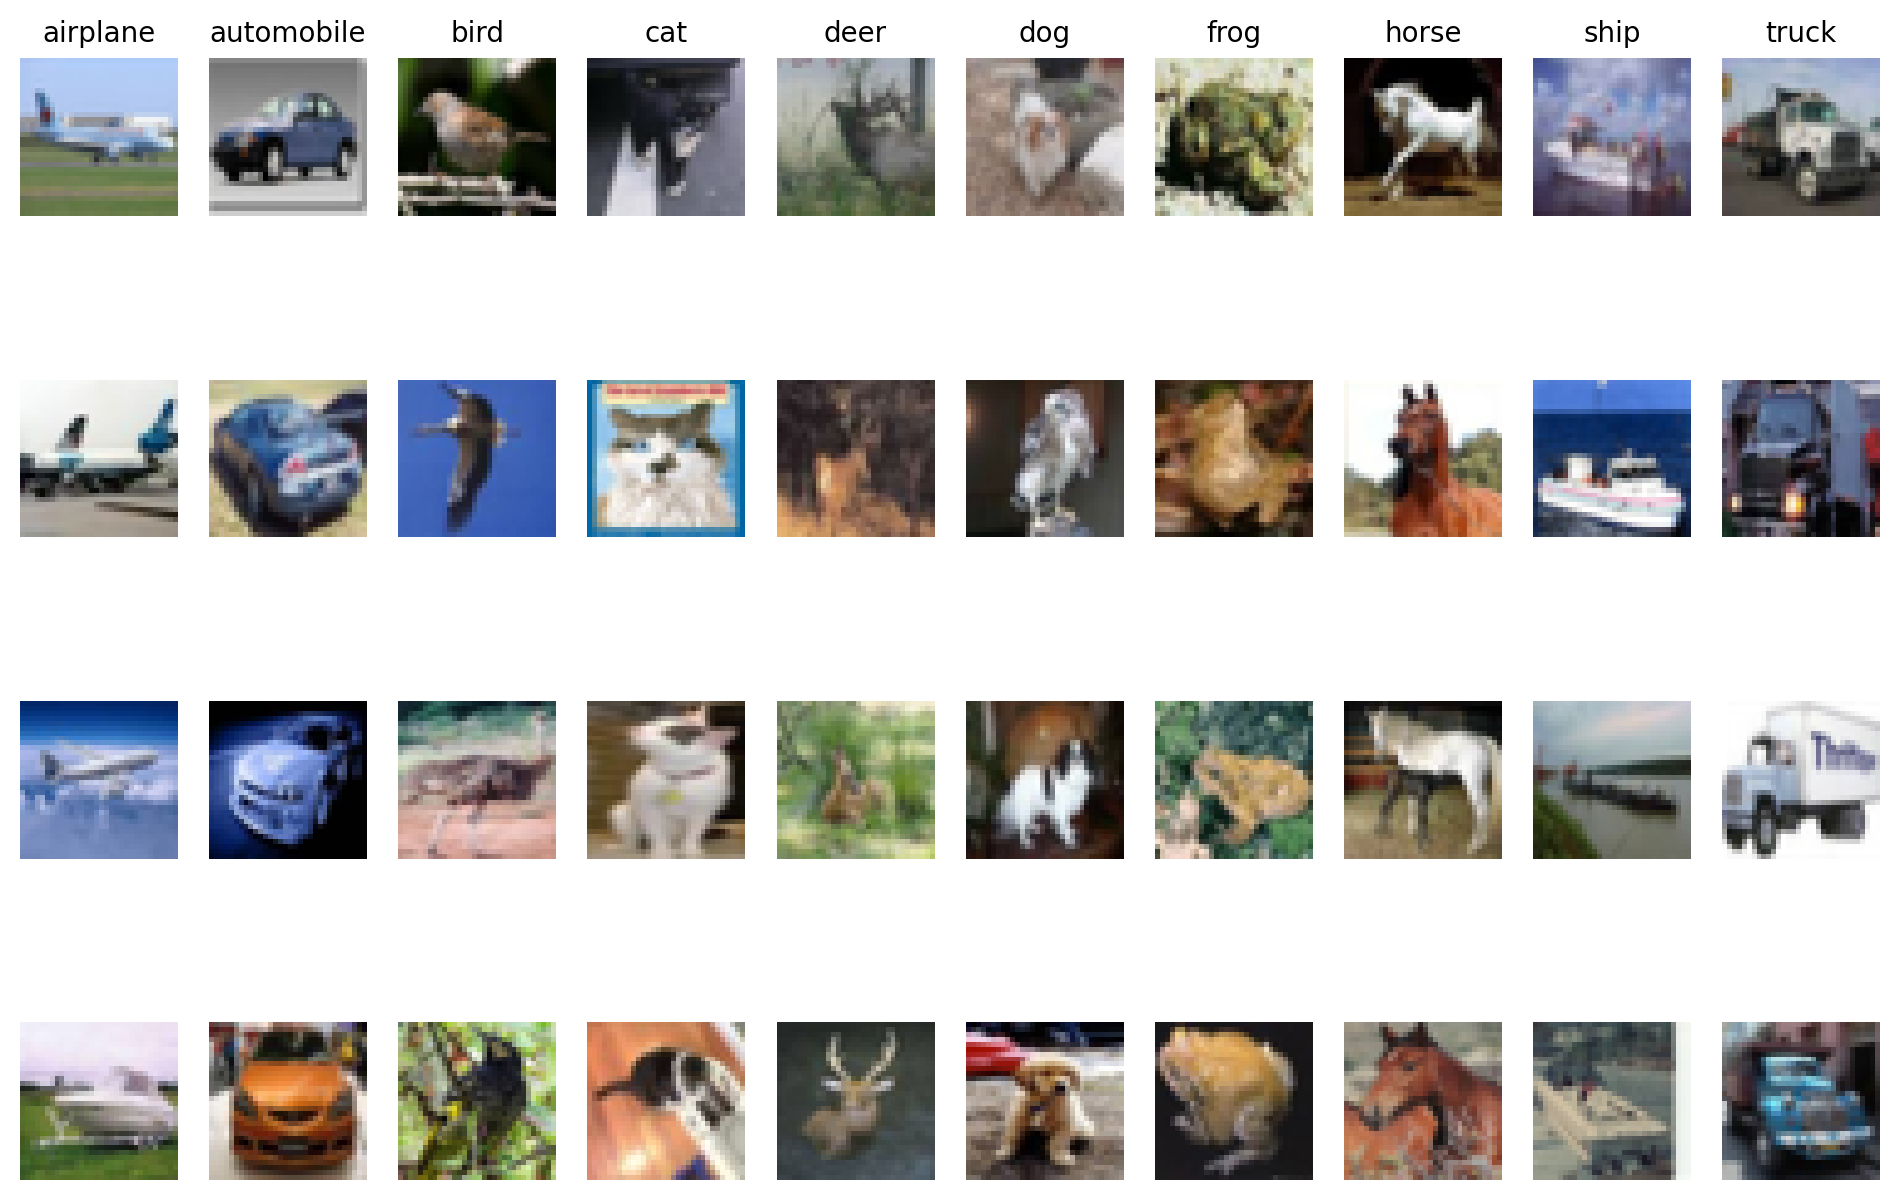

In [22]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building (Tuned 2) - VGG
   

### Import

In [3]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 12s 0us/step


### Data Preprocessing

In [4]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 

In [5]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [6]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [7]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_2')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                                 
Total params: 134,301,514
Trainable params: 134,301,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1563/1563 [===================

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 20s 65ms/step - loss: 0.4930 - accuracy: 0.9117
Test loss:  0.4929668605327606
Test accuracy: 0.9117000102996826


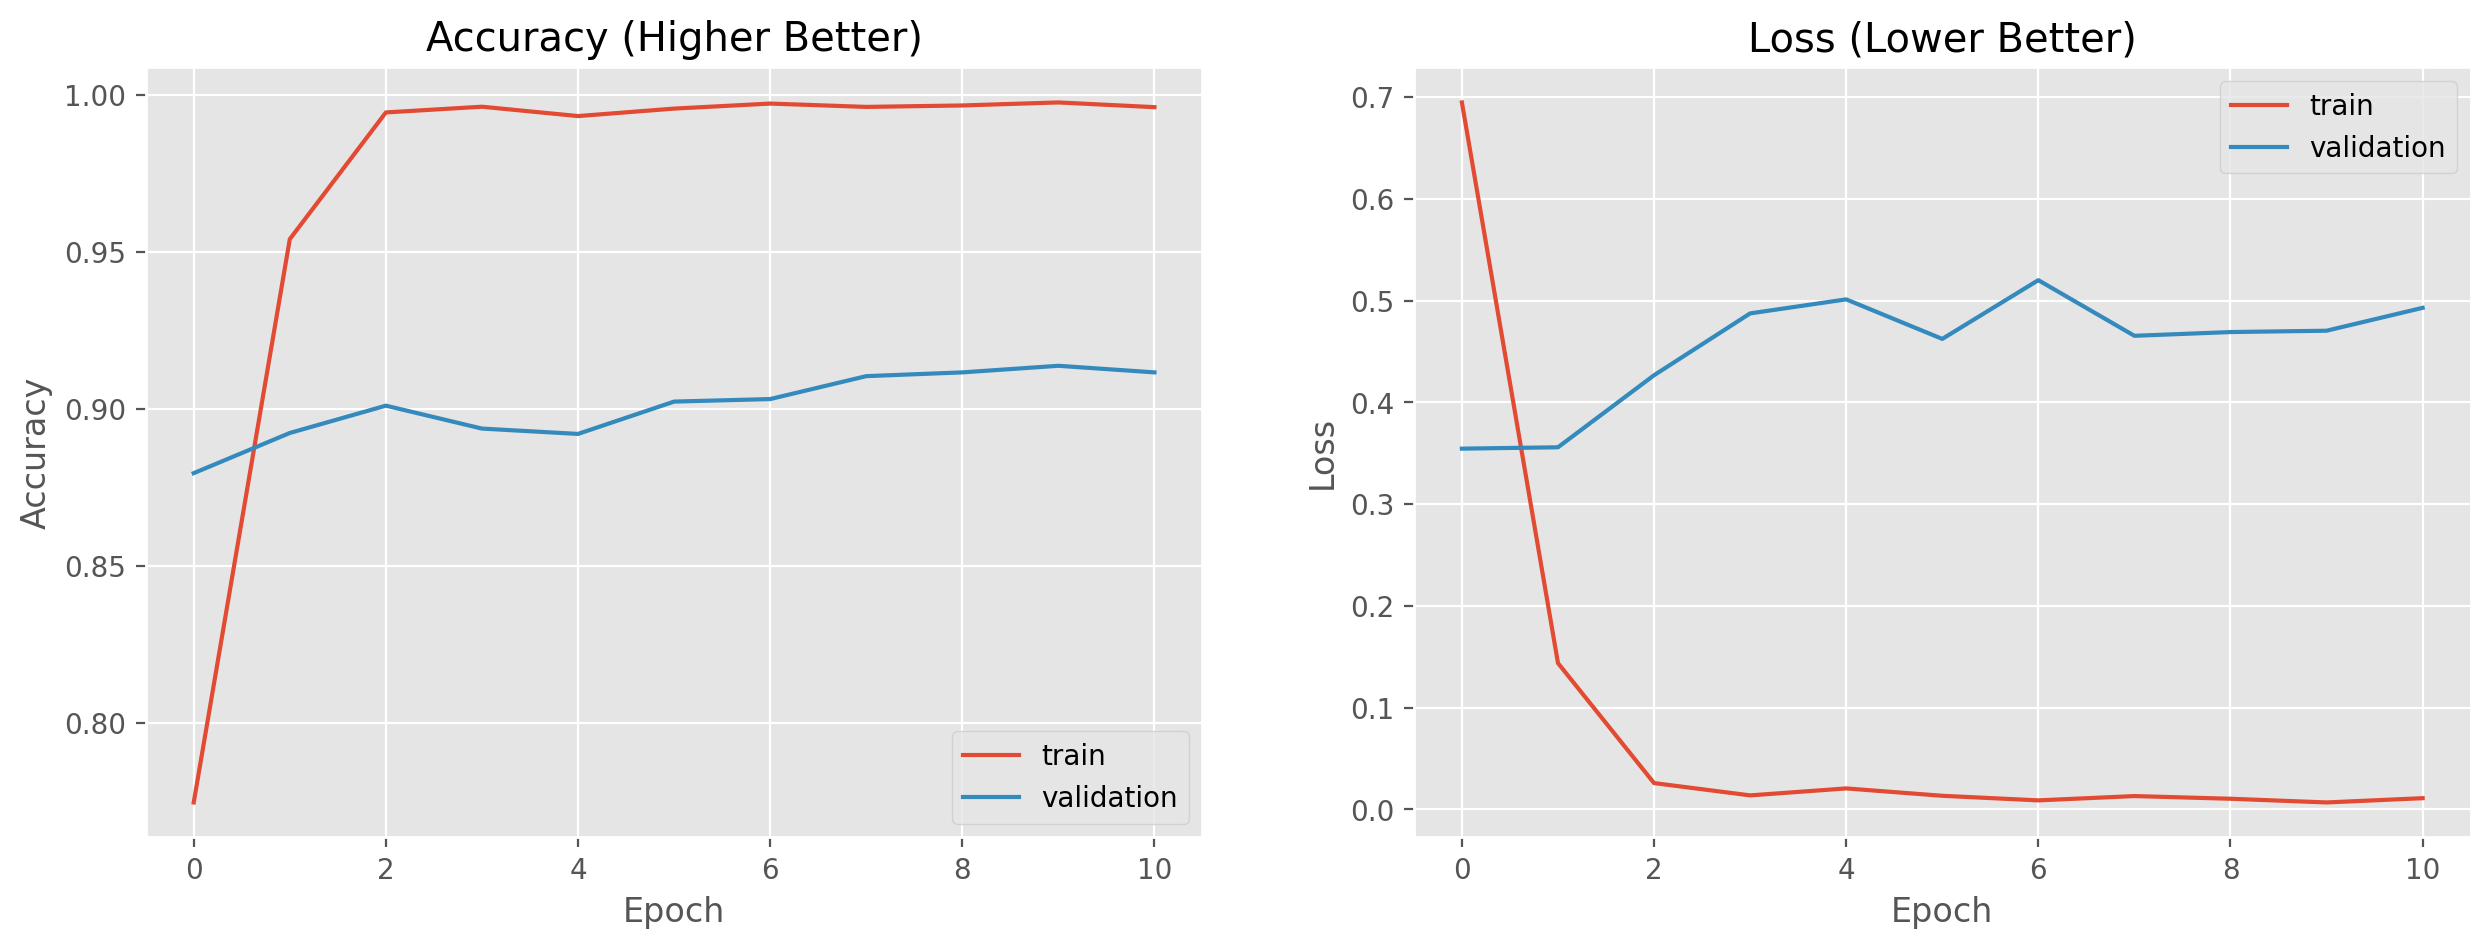

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [10]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 19s 59ms/step
[3 8 1 ... 5 1 7]


In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [12]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [13]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_32/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


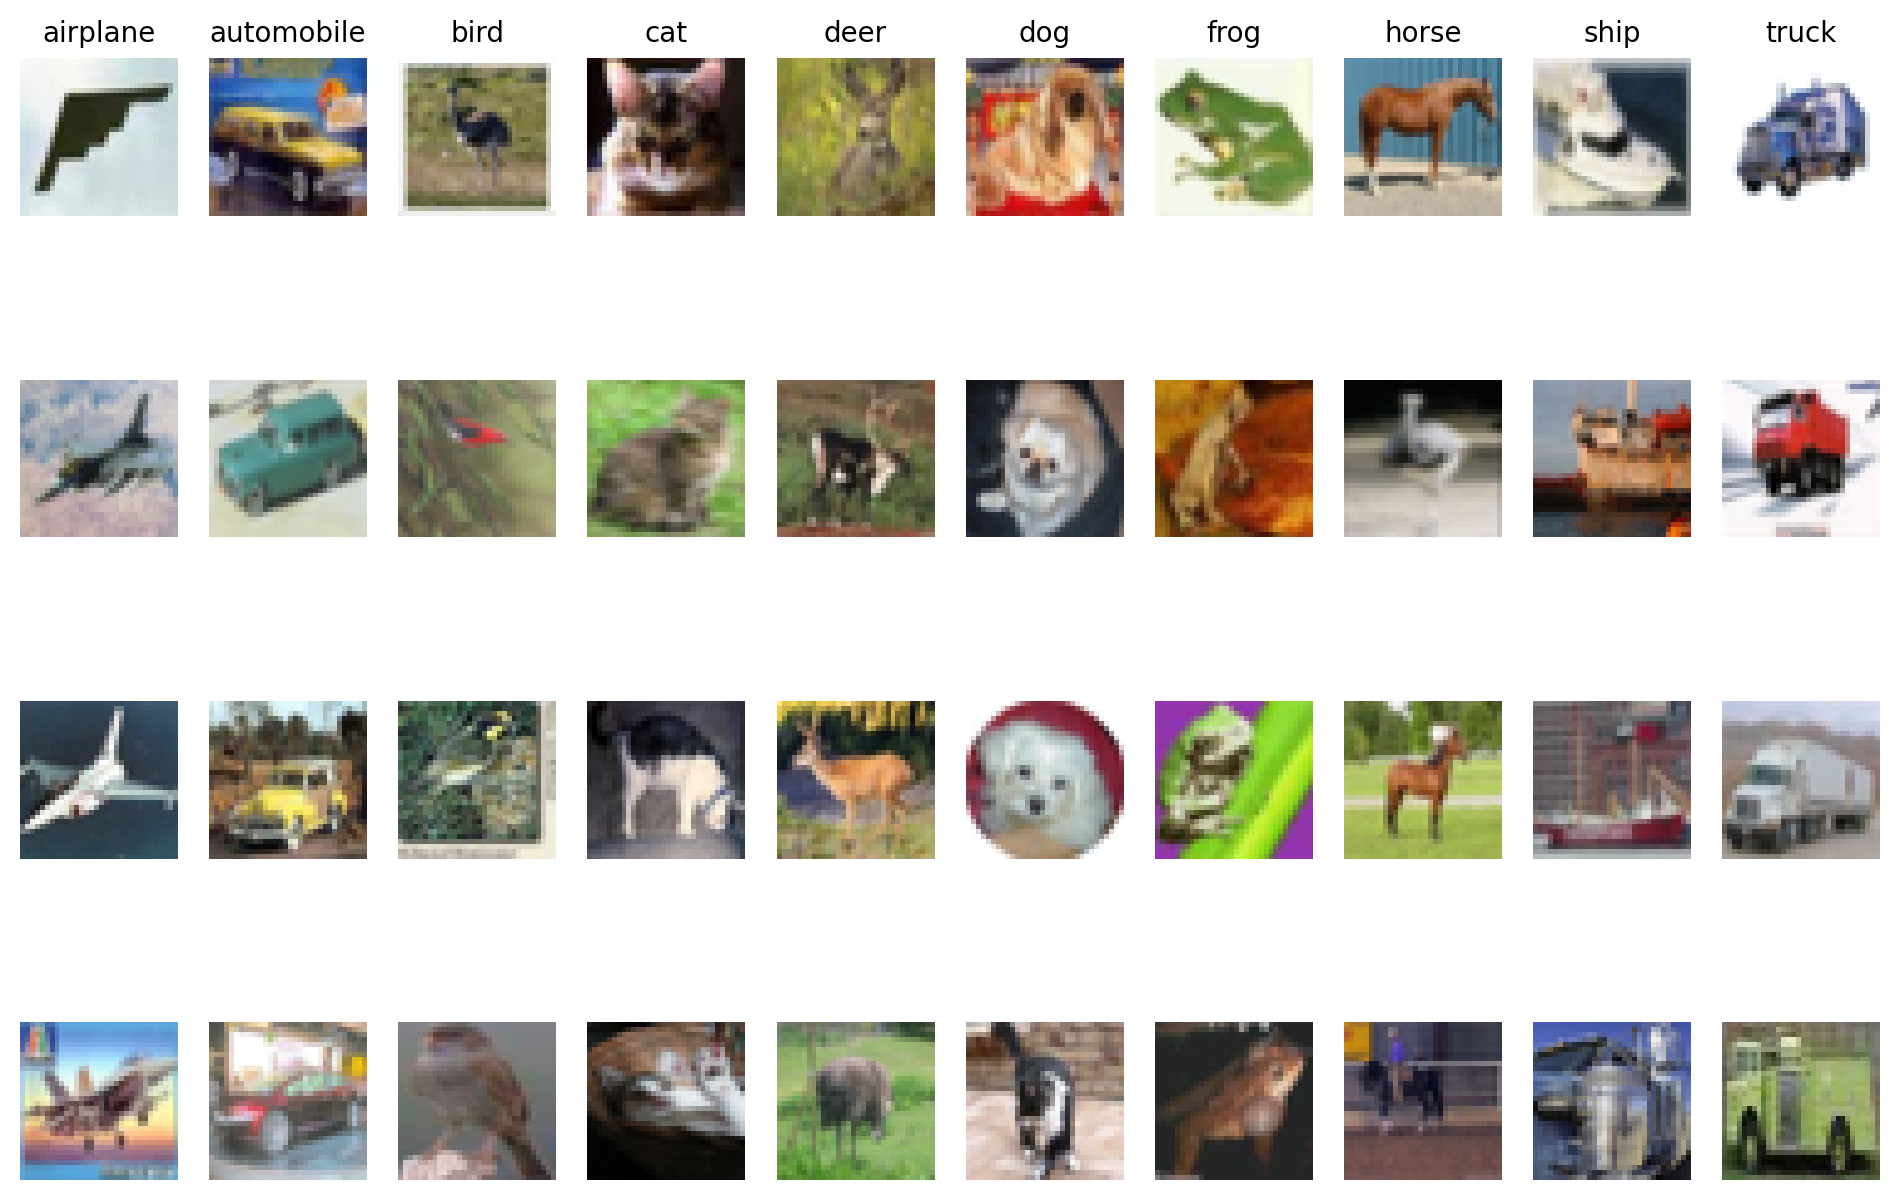

In [14]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building (Tuned 3) - VGG
   

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 
- Added kernel regularisers
- Added dropout

In [5]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [7]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_3')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                

2023-05-31 16:51:52.426583: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-05-31 16:51:52.970390: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 16:51:52.971316: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 16:51:52.971381: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-31 16:51:52.972296: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 16:51:52.972420: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


400/782 [==============>...............] - ETA: 1:34 - loss: 2.0762 - accuracy: 0.3471

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)

# <font color=maroon>Model Building (Tuned 4) - VGG
   

### Import

In [29]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [30]:
# using default image size
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    
    return image, label


# user keras preprocessing
x_train = keras.applications.vgg16.preprocess_input(x_train)
x_test = keras.applications.vgg16.preprocess_input(x_test)

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


batch_size = 32
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font> 
- Changed Trainable = True
- Increased epoch size to 50
- Added Early Stopping
- Added lr scheduler
- Increased lr scheduler
- Used two dense layers with 4098 input shape 
- Added kernel regularisers
- Added dropout
- Increased Dropout

In [31]:
# build vgg16 model
pre_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
# pre_model.trainable = False
for layer in pre_model.layers:
    layer.trainable=True

In [33]:
# build InceptionV3 model
model = Sequential(name='VGG_Tuned_4')
model.add(pre_model)
model.add(Flatten())

model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50


early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


model.summary()


def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]


model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                     callbacks=[early_stop, callback])

Model: "VGG_Tuned_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                

In [34]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 13s 41ms/step - loss: 1.1006 - accuracy: 0.9355
Test loss:  1.1005967855453491
Test accuracy: 0.9355000257492065


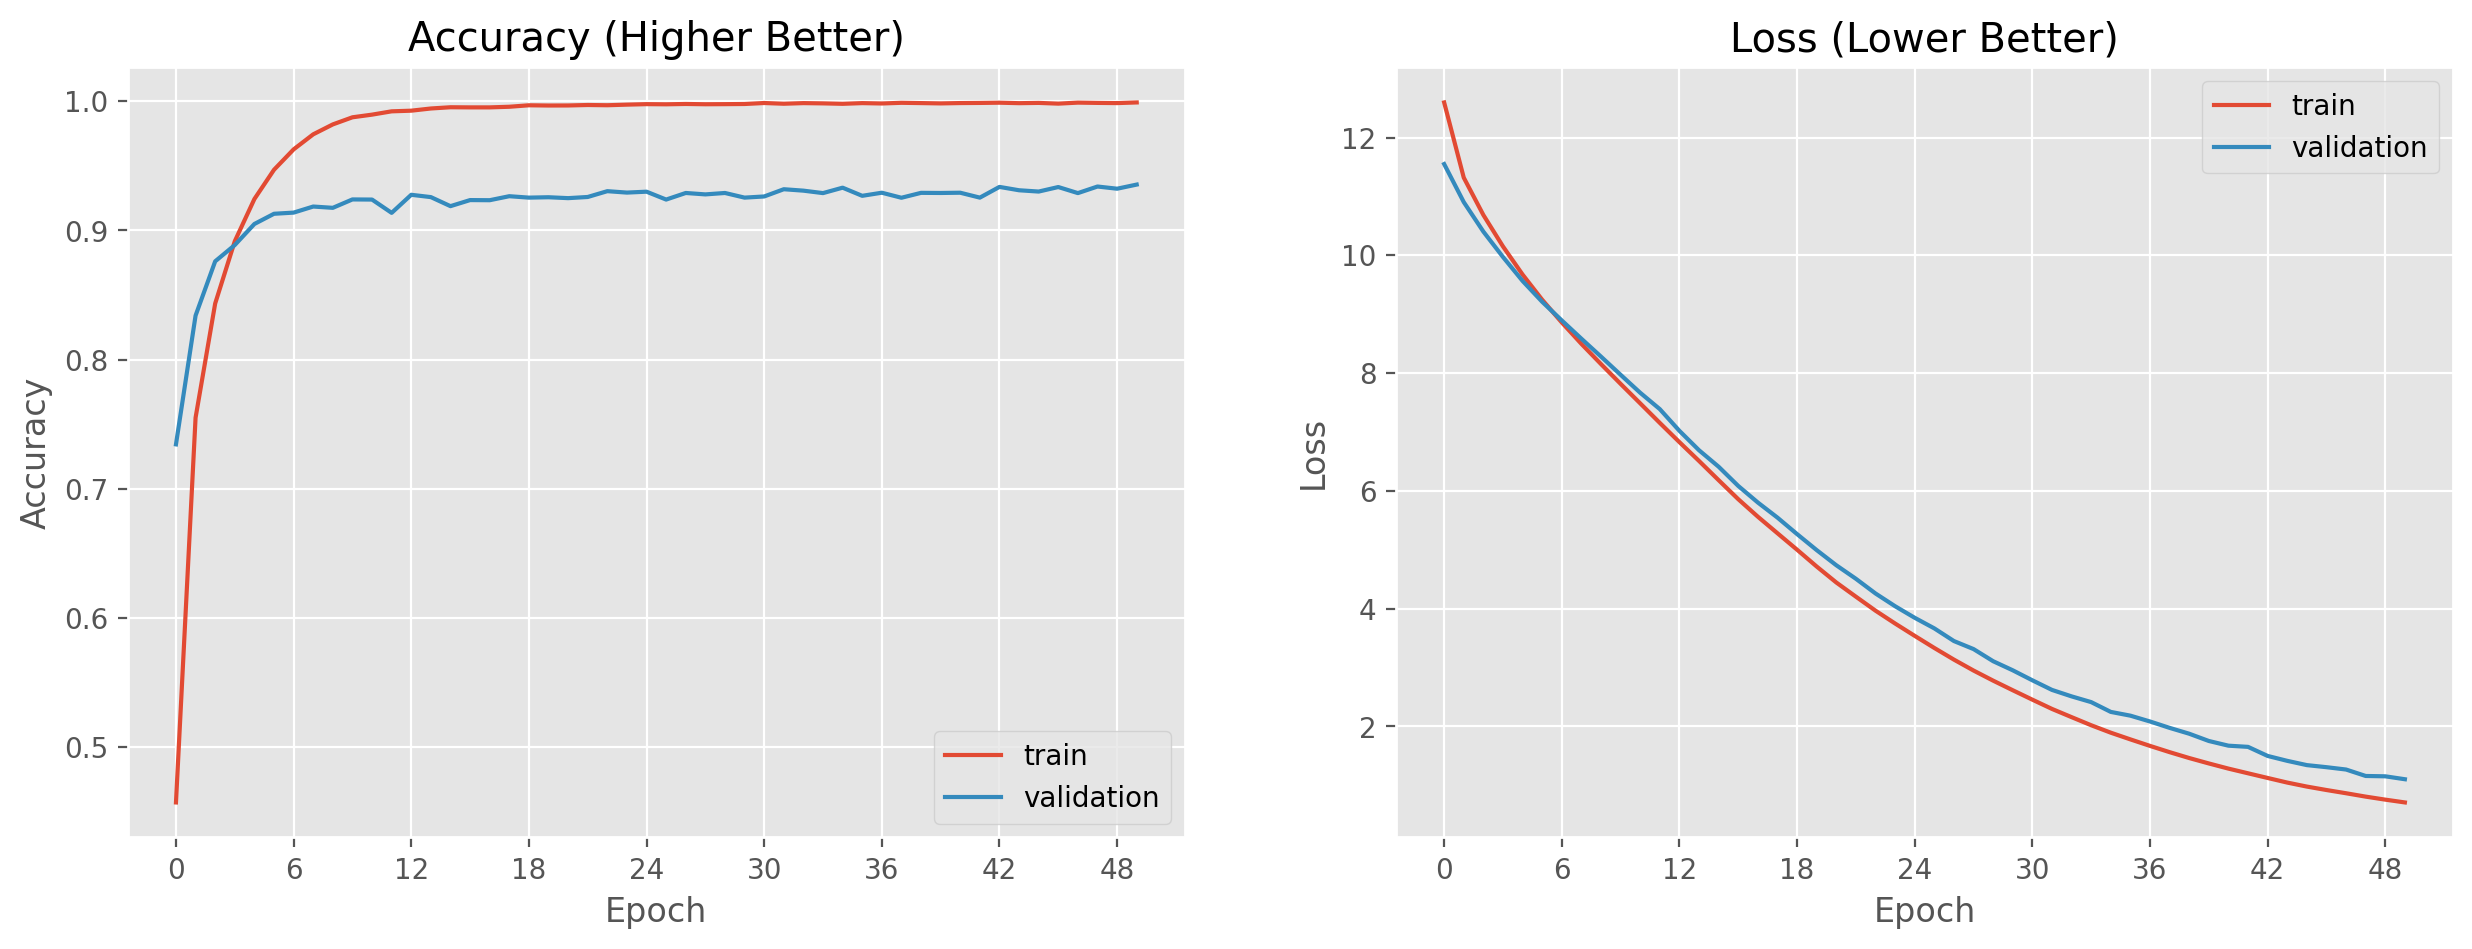

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [36]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

313/313 [==============================] - 12s 36ms/step
[3 8 8 ... 5 1 7]


In [37]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [38]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [39]:
print(err_x.shape)

(1000, 32, 32, 3)


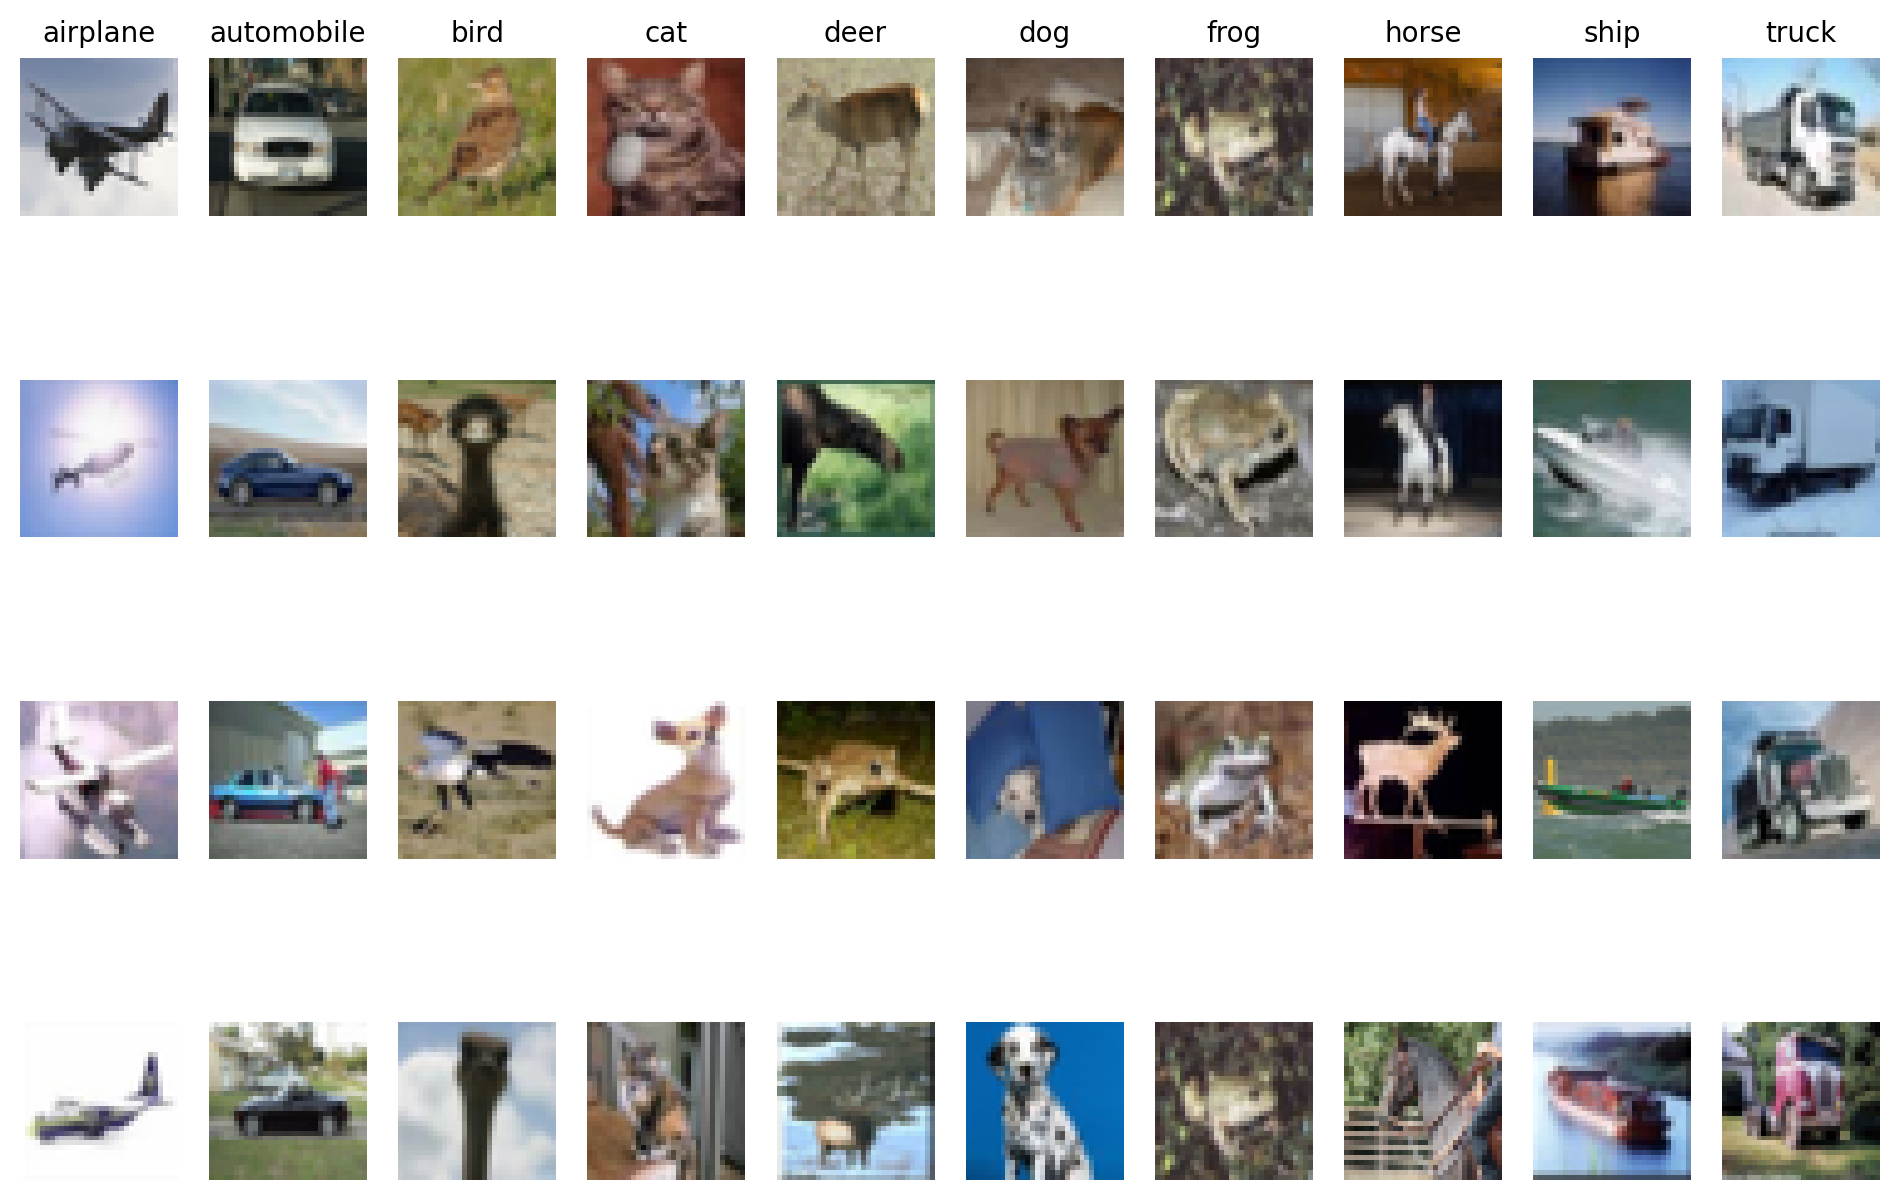

In [40]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)

In [41]:
# # convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()


# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

### <font color=maroon>Testing categorising on a single model

### Imports

In [42]:
import requests
from PIL import Image
from io import BytesIO

In [43]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

### Loading selected image from URL

In [44]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [45]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [46]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 0s 168ms/step


In [47]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [48]:
predicted_label = class_labels[predicted_class_index[0]]

In [49]:
print(predicted_label)


airplane


### <font color=maroon>Visualising confusion matrix

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [51]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [52]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9355


In [53]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.935870638428764
Recall: 0.9355
F1 Score: 0.9353699760936847


### Creating confusion matrix

In [54]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

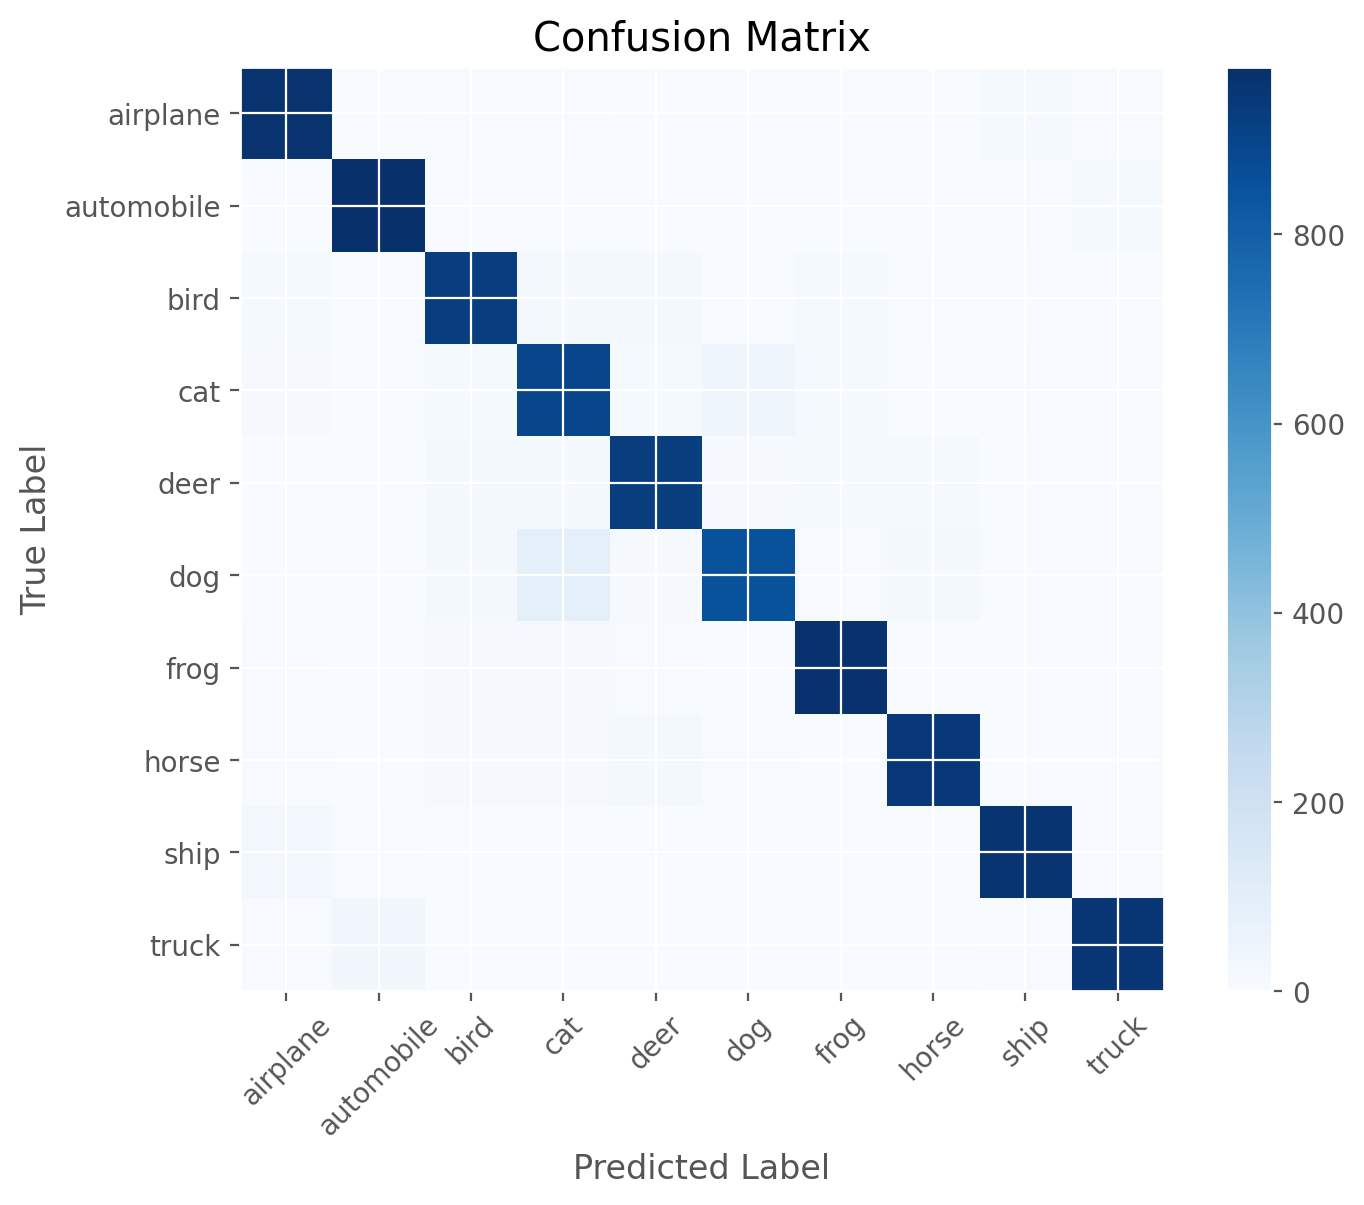

In [55]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
